# 7. Video content extraction using Azure Content Understanding

<img src="https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/media/overview/content-understanding-framework-2025.png#lightbox">

Azure Content Understanding in Foundry Tools is an Foundry Tool that's available as part of the Microsoft Foundry Resource in the Azure portal. It uses generative AI to process/ingest content of many types (documents, images, videos, and audio) into a user-defined output format. Content Understanding offers a streamlined process to reason over large amounts of unstructured data, accelerating time-to-value by generating an output that can be integrated into automation and analytical workflows.

Content Understanding is now a Generally Available (GA) service with the release of the 2025-11-01 API version. It's now available in a broader range of regions.

### Core Documentation
1. **[What is Azure Content Understanding in Foundry Tools?](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/overview)** - Main overview page
2. **[FAQ - Frequently Asked Questions](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/faq)** - Common questions and answers
3. **[Choosing the Right Tool: Document Intelligence vs Content Understanding](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/choosing-right-ai-tool)** - Comparison guide
4. **[Models and Deployments](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/concepts/models-deployments)** - Supported models configuration
5. **[Pricing Explainer](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/pricing-explainer)** - Pricing details and optimization

### Modality-Specific Documentation
6. **[Document Processing Overview](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/document/overview)** - Field extraction and grounding
7. **[Video Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/overview)** - Video analysis capabilities
8. **[Image Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/image/overview)** - Image extraction and analysis
9. **[Face Solutions (Preview)](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/face/overview)** - Face detection and recognition

### Additional Resources
10. **[Transparency Note](https://learn.microsoft.com/en-us/azure/ai-foundry/responsible-ai/content-understanding/transparency-note)** - Responsible AI information
11. **[Code Samples on GitHub](https://github.com/Azure-Samples/azure-ai-content-understanding-python)** - Python implementation examples
12. **[Azure Content Understanding Pricing](https://azure.microsoft.com/pricing/details/content-understanding/)** - Official pricing page

## Video Content
The `prebuilt-videoSearch` analyzer provides comprehensive analysis of video content, combining visual frame extraction, audio transcription, and AI-powered insights. It transforms raw video into RAG-ready structured output in both Markdown and JSON formats, enabling applications like media asset management, content categorization, and retrieval-augmented generation.

Key features include:
1. **Transcription with Diarization:** Converts audio to searchable WebVTT transcripts with speaker identification and multilingual support (same language handling as audio).
2. **Key Frame Extraction:** Intelligently extracts representative frames (~1 FPS) from each scene, embedded as markdown image references with timestamps (e.g., `![](keyFrame.400.jpg)`).
3. **Shot Detection:** Identifies video segment boundaries aligned with camera cuts and scene transitions, providing timestamps in `cameraShotTimesMs`.
4. **Segment-based Analysis:** Analyzes multiple frames per segment to identify actions, events, and themes rather than individual frame analysis.
5. **Custom Field Extraction:** Define business-specific fields (brands, categories, sentiment) that the generative model extracts from visual and audio content.
6. **Structured Output:** Content organized in GitHub Flavored Markdown with precise temporal alignment and JSON with detailed metadata.

For detailed information about video capabilities, elements, and markdown format, see [Video overview](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/overview), [Video elements](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/elements), and [AudioVisual markdown representation](https://learn.microsoft.com/en-us/azure/ai-services/content-understanding/video/markdown).

In [1]:
import cv2
import json
import matplotlib.pyplot as plt
import os
import sys

from azure.identity import DefaultAzureCredential
from datetime import datetime
from dotenv import load_dotenv
from helper.content_understanding_client import AzureContentUnderstandingClient
from helper.document_processor import DocumentProcessor
from helper.sample_helper import save_json_to_file 
from IPython.display import Video, FileLink
from PIL import Image
from typing import Optional, Dict, Any

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 02-Dec-2025 13:28:57


## 1. Azure Content Understanding client

In [4]:
load_dotenv("azure.env")

AZURE_AI_ENDPOINT = os.getenv("AZURE_AI_ENDPOINT")
API_VERSION = "2025-11-01"  # Subject to change. Check the documentation
GPT_4_1_DEPLOYMENT = "gpt-4.1"  # Name of the model deployed in Microsoft Foundry
GPT_4_1_MINI_DEPLOYMENT = "gpt-4.1-mini"  # Name of the model deployed in Microsoft Foundry
TEXT_EMBEDDING_3_LARGE_DEPLOYMENT = "text-embedding-3-large"  # Name of the model deployed in Microsoft Foundry

In [5]:
def token_provider():
    """Provides fresh Azure Cognitive Services tokens."""
    try:
        credential = DefaultAzureCredential()
        token = credential.get_token(
            "https://cognitiveservices.azure.com/.default")
        return token.token
    except Exception as e:
        print(f"❌ Token acquisition failed: {e}")
        raise


try:
    if not AZURE_AI_ENDPOINT or not API_VERSION:
        raise ValueError("AZURE_AI_ENDPOINT and API_VERSION must be set")

    print("Initializing Azure Content Understanding Client...")
    client = AzureContentUnderstandingClient(
        endpoint=AZURE_AI_ENDPOINT,
        api_version=API_VERSION,
        token_provider=token_provider,
        x_ms_useragent="azure-ai-content-understanding-python-sample-ga")
    print("✅ Done")

except ValueError as e:
    print(f"❌ Configuration error: {e}")
    raise
except Exception as e:
    print(f"❌ Client creation failed: {e}")
    raise

Initializing Azure Content Understanding Client...
✅ Done


In [6]:
missing_deployments = []

if not GPT_4_1_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_DEPLOYMENT")
if not GPT_4_1_MINI_DEPLOYMENT:
    missing_deployments.append("GPT_4_1_MINI_DEPLOYMENT")
if not TEXT_EMBEDDING_3_LARGE_DEPLOYMENT:
    missing_deployments.append("TEXT_EMBEDDING_3_LARGE_DEPLOYMENT")

if missing_deployments:
    print(f"❌ Warning: Missing required model deployment configuration(s):")
    for deployment in missing_deployments:
        print(f"   - {deployment}")
    print(
        "\n   Prebuilt analyzers require GPT-4.1, GPT-4.1-mini, and text-embedding-3-large deployments."
    )
    print("   Please:")
    print("   1. Deploy all three models in Azure AI Foundry")
    print("   2. Add the following to notebooks/.env:")
    print("      GPT_4_1_DEPLOYMENT=<your-gpt-4.1-deployment-name>")
    print("      GPT_4_1_MINI_DEPLOYMENT=<your-gpt-4.1-mini-deployment-name>")
    print(
        "      TEXT_EMBEDDING_3_LARGE_DEPLOYMENT=<your-text-embedding-3-large-deployment-name>"
    )
    print("   3. Restart the kernel and run this cell again")

else:
    print(f"📋 Configuring default model deployments...")
    print(f"   GPT-4.1 deployment: {GPT_4_1_DEPLOYMENT}")
    print(f"   GPT-4.1-mini deployment: {GPT_4_1_MINI_DEPLOYMENT}")
    print(
        f"   text-embedding-3-large deployment: {TEXT_EMBEDDING_3_LARGE_DEPLOYMENT}"
    )
    try:
        result = client.update_defaults({
            "gpt-4.1":
            GPT_4_1_DEPLOYMENT,
            "gpt-4.1-mini":
            GPT_4_1_MINI_DEPLOYMENT,
            "text-embedding-3-large":
            TEXT_EMBEDDING_3_LARGE_DEPLOYMENT
        })
        print(f"\n✅ Default model deployments configured successfully")
        print(f"   Model mappings:")
        for model, deployment in result.get("modelDeployments", {}).items():
            print(f"     {model} → {deployment}")
    except Exception as e:
        print(f"❌ Failed to configure defaults: {e}")
        print(f"   This may happen if:")
        print(
            f"   - One or more deployment names don't exist in your Azure AI Foundry project"
        )
        print(f"   - You don't have permission to update defaults")
        raise

📋 Configuring default model deployments...
   GPT-4.1 deployment: gpt-4.1
   GPT-4.1-mini deployment: gpt-4.1-mini
   text-embedding-3-large deployment: text-embedding-3-large

✅ Default model deployments configured successfully
   Model mappings:
     gpt-4.1 → gpt-4.1
     gpt-4.1-mini → gpt-4.1-mini
     text-embedding-3-large → text-embedding-3-large


In [7]:
try:
    defaults = client.get_defaults()
    print(f"✅ Retrieved default settings")

    model_deployments = defaults.get("modelDeployments", {})

    if model_deployments:
        print(f"\n✅ Model Deployments:")
        for model_name, deployment_name in model_deployments.items():
            print(f"   {model_name}: {deployment_name}")
    else:
        print("❌ No model deployments configured")

except Exception as e:
    print(f"❌  Error retrieving defaults: {e}")
    print("This is expected if no defaults have been configured yet.")

✅ Retrieved default settings

✅ Model Deployments:
   gpt-4.1: gpt-4.1
   gpt-4.1-mini: gpt-4.1-mini
   text-embedding-3-large: text-embedding-3-large


## 2. Video processing

In [8]:
DOCS_DIR = "documents"

In [9]:
video_file = os.path.join(DOCS_DIR, "video.mp4")
!ls $video_file -lh

-rwxrwxrwx 1 root root 15M Dec  2 11:04 documents/video.mp4


In [10]:
def get_video_duration(video_path):
    """
    Get and display the duration of a video file.
    
    Args:
        video_path (str): Path to the video file
        
    Returns:
        float: Duration in seconds (or None if error)
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file '{video_path}'")
        return None

    try:
        # Get FPS and frame count
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate duration
        duration_seconds = frame_count / fps if fps > 0 else 0

        # Format duration
        hours = int(duration_seconds // 3600)
        minutes = int((duration_seconds % 3600) // 60)
        seconds = int(duration_seconds % 60)
        milliseconds = int((duration_seconds % 1) * 1000)

        # Display
        if hours > 0:
            print(
                f"Duration: {hours:02d}:{minutes:02d}:{seconds:02d}.{milliseconds:03d}"
            )
        else:
            print(f"Duration: {minutes:02d}:{seconds:02d}.{milliseconds:03d}")

        print(f"Total: {duration_seconds:.2f} seconds")

    finally:
        cap.release()

In [11]:
get_video_duration(video_file)

Duration: 04:07.046
Total: 247.05 seconds


In [12]:
Video(video_file)

In [13]:
def save_keyframe_image_to_file(
    image_content: bytes,
    keyframe_id: str,
    test_name: str,
    test_py_file_dir: str,
    identifier: Optional[str] = None,
    output_dir: str = "results",
) -> str:
    """Save keyframe image to output file using pytest naming convention.

    Args:
        image_content: The binary image content to save
        keyframe_id: The keyframe ID (e.g., "keyframes/733")
        test_name: Name of the test case (e.g., function name)
        test_py_file_dir: Directory where pytest files are located
        identifier: Optional unique identifier to avoid conflicts (e.g., analyzer_id)
        output_dir: Directory name to save the output file (default: "results")

    Returns:
        str: Path to the saved image file

    Raises:
        OSError: If there are issues creating directory or writing file
    """
    # Generate timestamp and frame ID
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # Extract the frame time from the keyframe path (e.g., "keyframes/733" -> "733")
    if "/" in keyframe_id:
        frame_id = keyframe_id.split("/")[-1]
    else:
        # Fallback: use as-is if no slash found
        frame_id = keyframe_id

    # Create output directory if it doesn't exist
    output_dir_path = os.path.join(test_py_file_dir, output_dir)
    os.makedirs(output_dir_path, exist_ok=True)

    # Generate output filename with optional identifier to avoid conflicts
    if identifier:
        output_filename = f"{test_name}_{identifier}_{timestamp}_{frame_id}.jpg"
    else:
        output_filename = f"{test_name}_{timestamp}_{frame_id}.jpg"

    saved_file_path = os.path.join(output_dir_path, output_filename)

    # Write the image content to file
    with open(saved_file_path, "wb") as image_file:
        image_file.write(image_content)

    return saved_file_path

## 3. Using `prebuilt-videoSearch` 

In [14]:
analyzer_id = 'prebuilt-videoSearch'

# Analyze video file with the created analyzer
print(f"🔍 Analyzing video file from path: {video_file} with analyzer '{analyzer_id}'...")

# Begin video analysis operation
print(f"🎬 Starting video analysis with analyzer '{analyzer_id}'...")
analysis_response = client.begin_analyze_binary(
    analyzer_id=analyzer_id,
    file_location=video_file,
)

print(f"⏳ Waiting for video analysis to complete...")
analysis_result = client.poll_result(analysis_response)
print(f"✅ Video analysis completed successfully!")

🔍 Analyzing video file from path: documents/video.mp4 with analyzer 'prebuilt-videoSearch'...
🎬 Starting video analysis with analyzer 'prebuilt-videoSearch'...
⏳ Waiting for video analysis to complete...
✅ Video analysis completed successfully!


In [15]:
print("📄 Markdown Content")
print("\033[1;31;34m")

# Extract markdown from the first content element
contents = analysis_result.get("result", {}).get("contents", [])
if contents:
    content = contents[0]
    markdown = content.get("markdown", "")
    print(markdown)

📄 Markdown Content

# Video: 00:44.778 => 02:47.680
Width: 640
Height: 360

Transcript
```
WEBVTT

00:46.320 --> 00:49.920
<Speaker 6>Please confirm the patient's name, site and procedure.

00:50.480 --> 00:55.520
<Speaker 1>Right, we've got Mary Murray, date of birth 26/1/38.

00:56.160 --> 01:05.360
<Speaker 1>Unit number is 2170101 and we're doing a right total hip replacement and we've got a signed arrow marking the right hip.

01:08.160 --> 01:10.160
<Speaker 6>Here is the consent form signed.

01:10.400 --> 01:11.040
<Speaker 5>Thank you.

01:11.280 --> 01:14.560
<Speaker 5>The consent has been signed for a right total hip replacement.

01:15.360 --> 01:15.920
<Speaker 6>Does Mrs.

01:15.920 --> 01:17.680
<Speaker 6>Murray have any known allergies?

01:18.160 --> 01:20.160
<Speaker 5>Yes, she has an allergy to band-aids.

01:21.600 --> 01:24.000
<Speaker 6>Bev, can you please document that on the whiteboard?

01:24.320 --> 01:25.120
<Speaker 6>Certainly, Alison.

01:25.120 --> 01

In [16]:
if content.get("kind") == "audioVisual":
    video_visual_content = content
    print("🎬 Video-Visual Information")
    print("\033[1;31;34m")
    
    # Basic Video-Visual Details
    try:
        start_time = video_visual_content.get("startTimeMs")
        end_time = video_visual_content.get("endTimeMs")
        duration_sec = (end_time - start_time) / 1000
        print(f"Start Time: {start_time} ms")
        print(f"End Time: {end_time} ms")
        print(f"Duration: {duration_sec:.2f} seconds")
    except (KeyError, TypeError):
        print("❌ Missing basic audio-visual content details.")

    # Transcript Phrases (limit to 10)
    transcript_phrases = video_visual_content.get("transcriptPhrases", [])
    if transcript_phrases:
        print(f"\n📝 Transcript Phrases ({min(len(transcript_phrases), 10)}):")
        for idx, phrase in enumerate(transcript_phrases[:10]):
            print(f"  {idx + 1}. Speaker: {phrase.get('speaker')}")
            print(f"     Text: {phrase.get('text')}")
            print(
                f"     Start: {phrase.get('startTimeMs')} ms, End: {phrase.get('endTimeMs')} ms"
            )
            confidence = phrase.get('confidence', 0)
            print(f"     Confidence: {confidence:.2%}")
            print(f"     Locale: {phrase.get('locale')}")
        if len(transcript_phrases) > 10:
            print(f"  ... and {len(transcript_phrases) - 10} more.")
    else:
        print("\n📝 No transcript phrases available.")

    # Key Frames (support both keyFrameTimesMs and KeyFrameTimesMs for forward compatibility)
    key_frame_times_ms = video_visual_content.get(
        "keyFrameTimesMs") or video_visual_content.get("KeyFrameTimesMs", [])
    
    if key_frame_times_ms:
        print(f"\n🖼️ Key Frames ({len(key_frame_times_ms)}):")
        for idx, key_frame_time in enumerate(key_frame_times_ms[:5]):
            print(f"  Frame {idx + 1}: Time {key_frame_time} ms")
        if len(key_frame_times_ms) > 5:
            print(f"  ... and {len(key_frame_times_ms) - 5} more.")
    else:
        print("\n🖼️ No key frame data available.")

    # Markdown Preview
    if markdown:
        print("\n🎵 Markdown Content Preview:")
        print(markdown[:200] + ("..." if len(markdown) > 200 else ""))
    else:
        print("\n🎵 No Markdown content available.")
else:
    print("\n🎬 Video-Visual Information: Not available for this content type.")

🎬 Video-Visual Information

Start Time: 44778 ms
End Time: 167680 ms
Duration: 122.90 seconds

📝 Transcript Phrases (10):
  1. Speaker: Speaker 6
     Text: Please confirm the patient's name, site and procedure.
     Start: 46320 ms, End: 49920 ms
     Confidence: 75.40%
     Locale: en-US
  2. Speaker: Speaker 1
     Text: Right, we've got Mary Murray, date of birth 26/1/38.
     Start: 50480 ms, End: 55520 ms
     Confidence: 75.40%
     Locale: en-US
  3. Speaker: Speaker 1
     Text: Unit number is 2170101 and we're doing a right total hip replacement and we've got a signed arrow marking the right hip.
     Start: 56160 ms, End: 65360 ms
     Confidence: 90.90%
     Locale: en-US
  4. Speaker: Speaker 6
     Text: Here is the consent form signed.
     Start: 68160 ms, End: 70160 ms
     Confidence: 90.90%
     Locale: en-US
  5. Speaker: Speaker 5
     Text: Thank you.
     Start: 70400 ms, End: 71040 ms
     Confidence: 90.90%
     Locale: en-US
  6. Speaker: Speaker 5
     Text: 

In [17]:
saved_json_path = save_json_to_file(analysis_result, filename_prefix="content_analyzers_video")
print(f"📋 Full analysis result saved. Review the complete JSON at: {saved_json_path}")

💾 Analysis result saved to: results/content_analyzers_video_20251202_133104.json
📋 Full analysis result saved. Review the complete JSON at: results/content_analyzers_video_20251202_133104.json


In [18]:
!ls $saved_json_path -lh

-rwxrwxrwx 1 root root 100K Dec  2 13:31 results/content_analyzers_video_20251202_133104.json


## 5. Display all the results

In [19]:
with open(saved_json_path, 'r') as file:
    data = json.load(file)
    print("\033[1;31;34m")
    print(json.dumps(data, indent=5))


{
     "id": "8f4056a5-7d2a-48ba-8ab6-3d3a7784db11",
     "status": "Succeeded",
     "result": {
          "analyzerId": "prebuilt-videoSearch",
          "apiVersion": "2025-11-01",
          "createdAt": "2025-12-02T13:28:59Z",
          "warnings": [],
          "contents": [
               {
                    "markdown": "# Video: 00:44.778 => 02:47.680\nWidth: 640\nHeight: 360\n\nTranscript\n```\nWEBVTT\n\n00:46.320 --> 00:49.920\n<Speaker 6>Please confirm the patient's name, site and procedure.\n\n00:50.480 --> 00:55.520\n<Speaker 1>Right, we've got Mary Murray, date of birth 26/1/38.\n\n00:56.160 --> 01:05.360\n<Speaker 1>Unit number is 2170101 and we're doing a right total hip replacement and we've got a signed arrow marking the right hip.\n\n01:08.160 --> 01:10.160\n<Speaker 6>Here is the consent form signed.\n\n01:10.400 --> 01:11.040\n<Speaker 5>Thank you.\n\n01:11.280 --> 01:14.560\n<Speaker 5>The consent has been signed for a right total hip replacement.\n\n01:15.360 -

In [20]:
with open(saved_json_path, 'r') as file:
    data = json.load(file)

for content in data['result']['contents']:
    print("\033[1;31;34m")
    if 'markdown' in content:
        print(content['markdown'])
        print("\n" + "="*80 + "\n")


# Video: 00:44.778 => 02:47.680
Width: 640
Height: 360

Transcript
```
WEBVTT

00:46.320 --> 00:49.920
<Speaker 6>Please confirm the patient's name, site and procedure.

00:50.480 --> 00:55.520
<Speaker 1>Right, we've got Mary Murray, date of birth 26/1/38.

00:56.160 --> 01:05.360
<Speaker 1>Unit number is 2170101 and we're doing a right total hip replacement and we've got a signed arrow marking the right hip.

01:08.160 --> 01:10.160
<Speaker 6>Here is the consent form signed.

01:10.400 --> 01:11.040
<Speaker 5>Thank you.

01:11.280 --> 01:14.560
<Speaker 5>The consent has been signed for a right total hip replacement.

01:15.360 --> 01:15.920
<Speaker 6>Does Mrs.

01:15.920 --> 01:17.680
<Speaker 6>Murray have any known allergies?

01:18.160 --> 01:20.160
<Speaker 5>Yes, she has an allergy to band-aids.

01:21.600 --> 01:24.000
<Speaker 6>Bev, can you please document that on the whiteboard?

01:24.320 --> 01:25.120
<Speaker 6>Certainly, Alison.

01:25.120 --> 01:25.760
<Speaker 5>

# 6. Keyframes

In [21]:
def extract_keyframe_ids(analysis_result: Dict[str, Any]) -> list[str]:
    """
    Extract all keyframe IDs from the analysis result.

    Args:
        analysis_result: The analysis result from the analyzer
    Returns:
        List of keyframe IDs (e.g., 'keyframes/1000', 'keyframes/2000')
    """
    print("Starting keyframe extraction from analysis result...")
    keyframe_ids = []
    contents = analysis_result.get("result", {}).get("contents", [])

    for idx, content in enumerate(contents):
        if content.get("kind") == "audioVisual":
            print(f"Found audioVisual content at index {idx}:")
            key_frame_times_ms = content.get("keyFrameTimesMs") or content.get(
                "KeyFrameTimesMs", [])

            if key_frame_times_ms:
                print(f"  Found {len(key_frame_times_ms)} keyframe timestamps")
                for time_ms in key_frame_times_ms:
                    keyframe_id = f"keyframes/{time_ms}"
                    keyframe_ids.append(keyframe_id)
            else:
                print(
                    f"  No keyframe timestamps found in this audioVisual content."
                )
    print(
        f"\nExtracted {len(keyframe_ids)} total keyframe IDs: {keyframe_ids}")

    return keyframe_ids

In [22]:
nbframes = 20

keyframe_ids = extract_keyframe_ids(analysis_result)
frames_list = []

if keyframe_ids:
    print(f"\n🖼️ Downloading {len(keyframe_ids)} keyframe images...")

    files_to_download = keyframe_ids[:min(nbframes, len(keyframe_ids))]
    print(
        f"Files to download (first {len(files_to_download)}): {files_to_download}"
    )

    for keyframe_id in files_to_download:
        print(f"\n✅ Getting result file: {keyframe_id}")

        image_content = client.get_result_file(
            analyze_response=analysis_response,
            file_id=keyframe_id,
        )

        if image_content:
            print(
                f"   Retrieved image file for {keyframe_id} ({len(image_content)} bytes)"
            )

            saved_file_path = save_keyframe_image_to_file(
                image_content=image_content,
                keyframe_id=keyframe_id,
                test_name="content_extraction_video",
                test_py_file_dir=os.getcwd(),
                identifier=analyzer_id)
            print(f"   Saved keyframe image to: {saved_file_path}")
            frames_list.append(saved_file_path)
        else:
            print(f"❌ No image content retrieved for keyframe: {keyframe_id}")
else:
    print("\n❌ No keyframe IDs found in analysis result.")

Starting keyframe extraction from analysis result...
Found audioVisual content at index 0:
  Found 124 keyframe timestamps
Found audioVisual content at index 1:
  Found 81 keyframe timestamps

Extracted 205 total keyframe IDs: ['keyframes/44778', 'keyframes/45379', 'keyframes/46713', 'keyframes/47481', 'keyframes/48248', 'keyframes/49016', 'keyframes/49783', 'keyframes/51218', 'keyframes/51818', 'keyframes/53020', 'keyframes/53654', 'keyframes/54922', 'keyframes/55556', 'keyframes/56790', 'keyframes/57357', 'keyframes/58592', 'keyframes/59293', 'keyframes/59993', 'keyframes/61461', 'keyframes/62229', 'keyframes/62996', 'keyframes/63764', 'keyframes/64531', 'keyframes/66066', 'keyframes/66800', 'keyframes/68368', 'keyframes/69169', 'keyframes/69970', 'keyframes/71405', 'keyframes/72072', 'keyframes/72739', 'keyframes/74174', 'keyframes/74908', 'keyframes/76343', 'keyframes/77044', 'keyframes/78445', 'keyframes/79179', 'keyframes/80614', 'keyframes/81315', 'keyframes/82015', 'keyframes/8

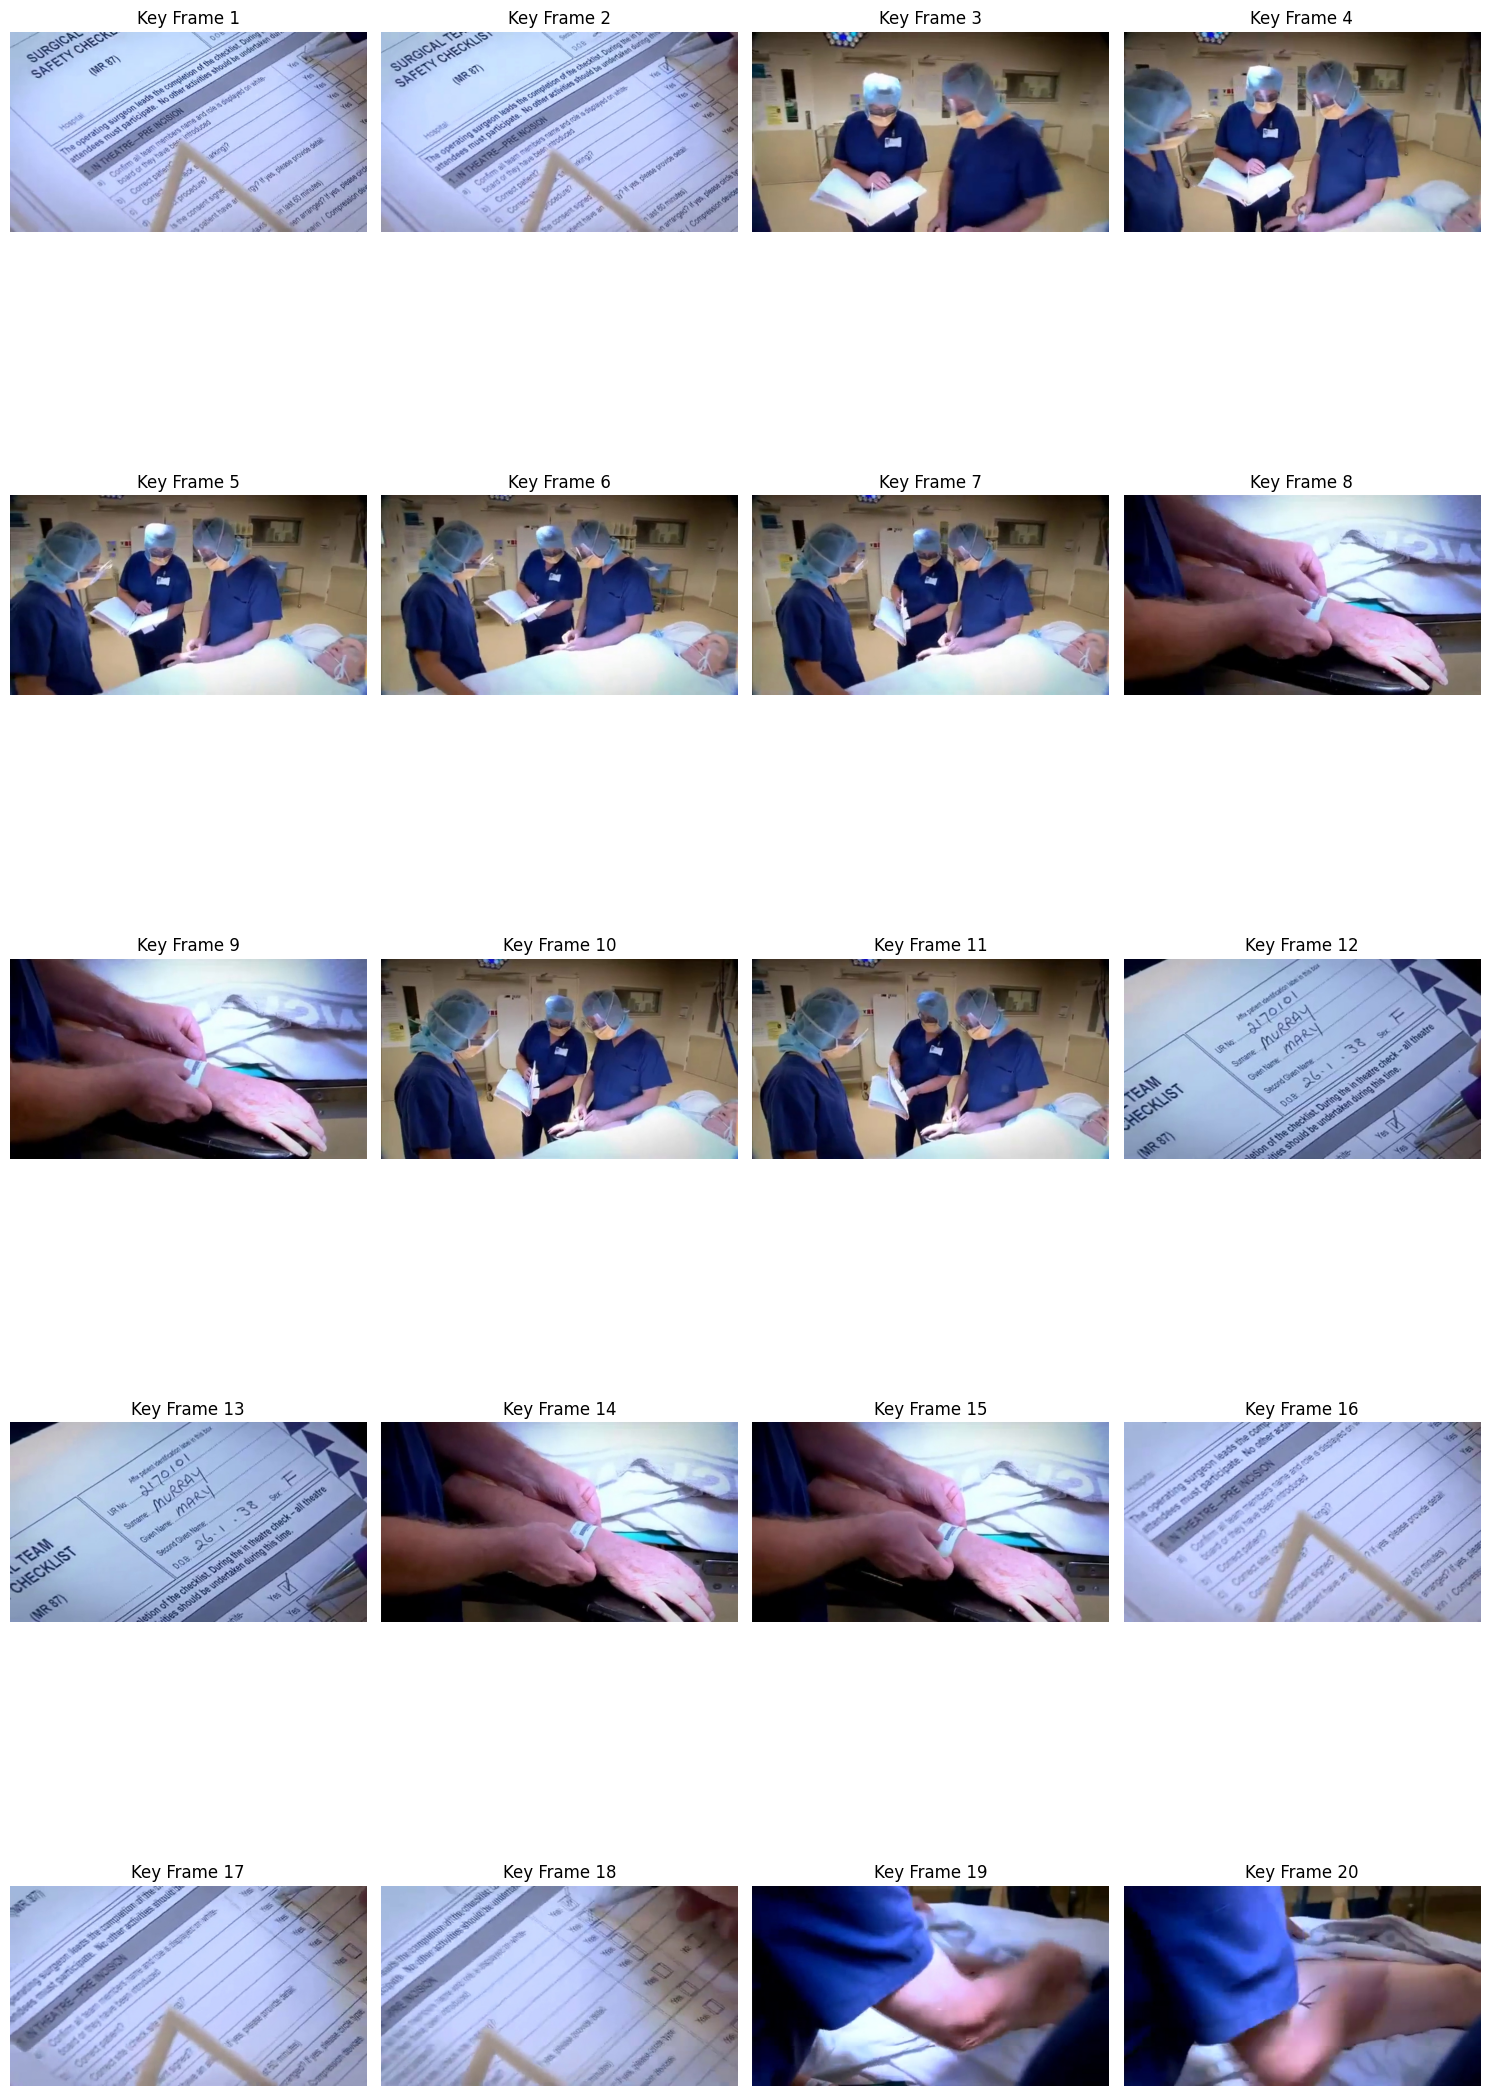

In [23]:
n_frames = len(frames_list)
cols = 4  # Number of columns
rows = (n_frames + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if n_frames > 1 else [axes]

for idx, frame in enumerate(frames_list):
    img = Image.open(frame)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Key Frame {idx+1}')

for idx in range(n_frames, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()